<a href="https://colab.research.google.com/github/mauricef/jax-ml/blob/main/mean_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-3d03d336-9a16-1872-73bd-cd4848b5c6e3)


In [2]:
from functools import partial
from jax import random, jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
rng = random.PRNGKey(42)

In [4]:
dimensions = 2
cluster_count = 6
cluster_scale = 100.
cluster_bw = 8.
sample_count = 250
sample_scale = np.sqrt(5.)

In [5]:
r, rng = random.split(rng)
cluster_eps = random.uniform(r, shape=(dimensions,))
cluster_center = cluster_scale * cluster_eps

In [6]:
rng, r = random.split(rng)
sample_eps = random.normal(r, shape=(sample_count, dimensions))
sample = cluster_center + sample_scale * sample_eps
sample.shape

(250, 2)

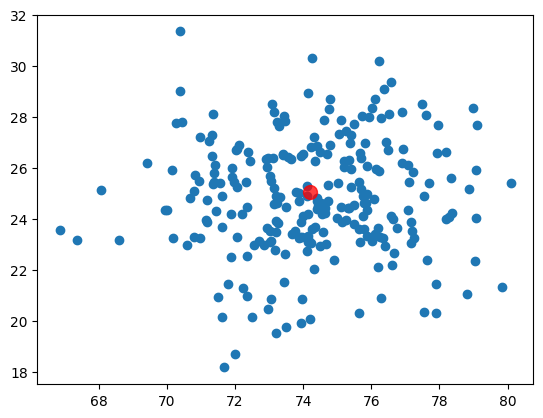

In [7]:
fig, ax = plt.subplots()
ax.scatter(sample[:,0], sample[:,1])
ax.plot(cluster_center[0], cluster_center[1], marker='o', markersize=10, color='r', alpha=.75)

In [8]:
@jit
def sample_cluster_center(rng):
    cluster_eps = random.uniform(rng, shape=(dimensions,))
    return cluster_scale * cluster_eps

In [9]:
@jit
def sample_cluster(rng, center):
    rng, r = random.split(rng)
    sample_eps = random.normal(r, shape=(sample_count, dimensions))
    sample = center + sample_scale * sample_eps
    return sample

In [10]:
def plot_center(ax, center):
    ax.plot(center[0], center[1], marker='o', markersize=10, color='r', alpha=.75)

In [11]:
def plot_sample(ax, sample):
    ax.scatter(sample[:,0], sample[:,1])

In [12]:
def plot_cluster(ax, center, sample):
    plot_sample(ax, sample)
    plot_center(ax, center)

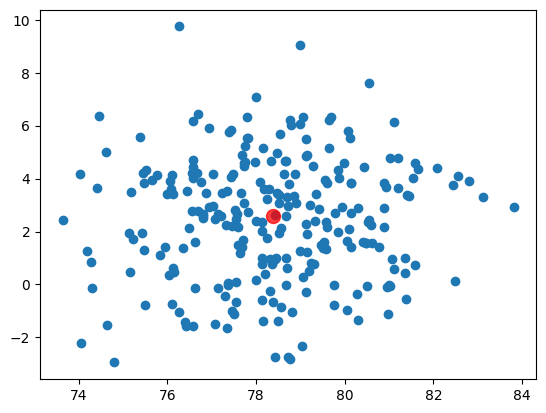

In [13]:
rng, r = random.split(rng)
center = sample_cluster_center(r)
rng, r = random.split(rng)
sample = sample_cluster(r, center)
fig, ax = plt.subplots()
plot_cluster(ax, center, sample)

In [14]:
rng, *r = random.split(rng, cluster_count + 1)
centers = vmap(sample_cluster_center)(np.array(r))
centers.shape

(6, 2)

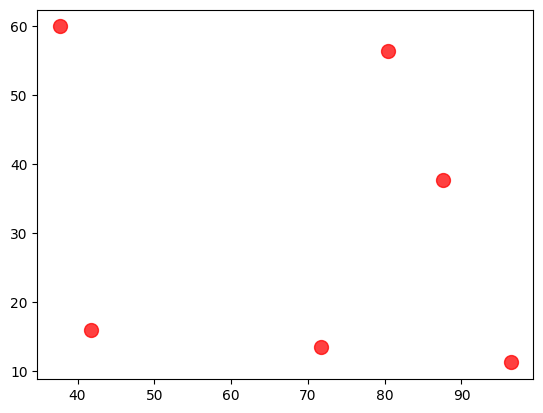

In [15]:
fig, ax = plt.subplots()
for center in centers:
    plot_center(ax, center)

In [16]:
rng, *r = random.split(rng, cluster_count + 1)
samples = vmap(sample_cluster)(np.array(r), centers)
samples.shape

(6, 250, 2)

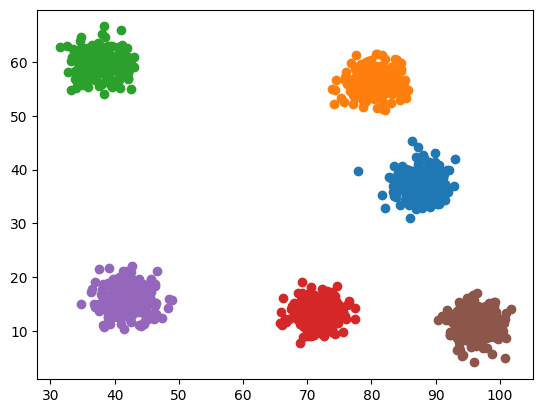

In [17]:
fig, ax = plt.subplots()
for sample in samples:
    plot_sample(ax, sample)

In [18]:
x0, x1 = jnp.array([[0, 0], [3, 4]])
jnp.sqrt(jnp.square(x0 - x1).sum())

Array(5., dtype=float32)

In [19]:
@jit
def euclidian_distance(x0, x1):
    return jnp.sqrt(jnp.square(x0 - x1).sum())

euclidian_distance(x0, x1)

Array(5., dtype=float32)

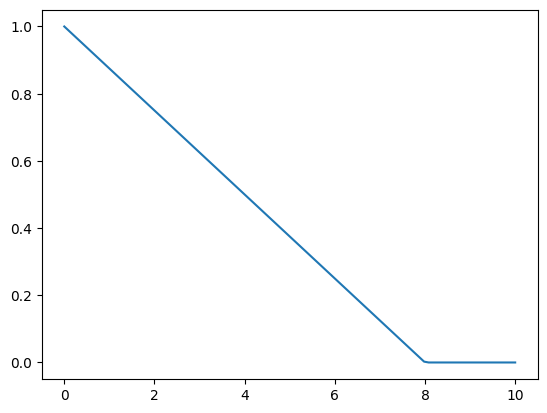

In [20]:
@jit
def distance_to_weight(distance, bandwidth):
    return jnp.maximum(0, bandwidth - distance) / bandwidth
x = np.linspace(0, 10, 100)
y = distance_to_weight(x, cluster_bw)
plt.plot(x, y)

In [21]:
x = jnp.reshape(samples, (-1, dimensions))
x.shape

(1500, 2)

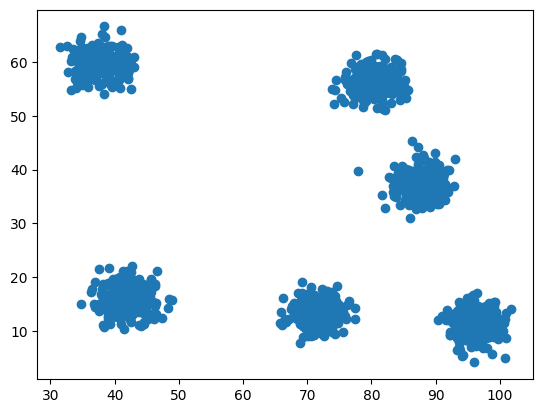

In [22]:
fig, ax = plt.subplots()
plot_sample(ax, x)

In [23]:
x0 = x[0]
distances = vmap(partial(euclidian_distance, x0))(x)
distances.shape

(1500,)

(array([163.,  89., 149.,  99., 137., 345.,  18.,  33., 354., 113.]),
 array([ 0.        ,  5.77275419, 11.54550838, 17.3182621 , 23.09101677,
        28.86377144, 34.6365242 , 40.40927887, 46.18203354, 51.95478821,
        57.72754288]),
 <BarContainer object of 10 artists>)

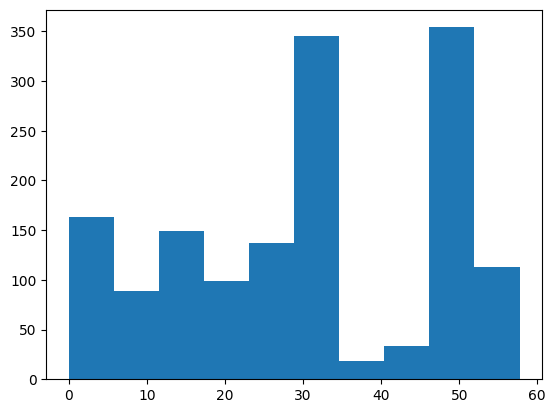

In [24]:
plt.hist(distances)

In [25]:
weights = distance_to_weight(distances, bandwidth=cluster_bw)
weights.shape

(1500,)

In [26]:
np.sum(weights > 0)

Array(239, dtype=int32)

In [27]:
weights.shape, x.shape

((1500,), (1500, 2))

In [28]:
weighted_mean = jnp.einsum('i,ij->j', weights, x) / weights.sum()
weighted_mean

Array([86.75617, 38.28496], dtype=float32)

In [29]:
@jit
def new_position(x, bw, xi):
    distances = vmap(partial(euclidian_distance, xi))(x)
    weights = distance_to_weight(distances, bw)
    return jnp.einsum('i,ij->j', weights, x) / weights.sum()

In [30]:
new_position(x, cluster_bw, x[0])

Array([86.75617, 38.28496], dtype=float32)

In [31]:
next_x = vmap(partial(new_position, x, cluster_bw))(x)
next_x.shape

(1500, 2)

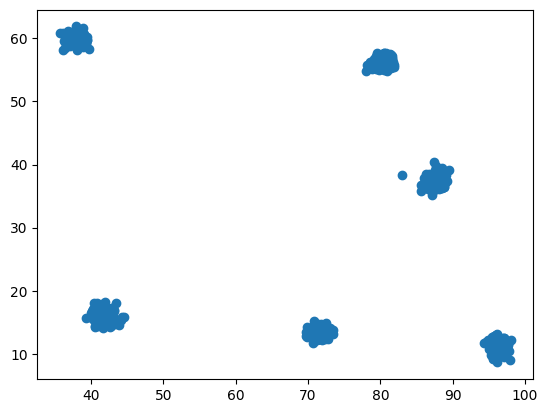

In [32]:
fix, ax = plt.subplots()
plot_sample(ax, next_x)

In [33]:
@jit
def step(x, bw):
    return vmap(partial(new_position, x, bw))(x)

In [34]:
def meanshift(x, bw, steps):
    for i in range(steps):
        x = step(x, bw=bw)
    return x

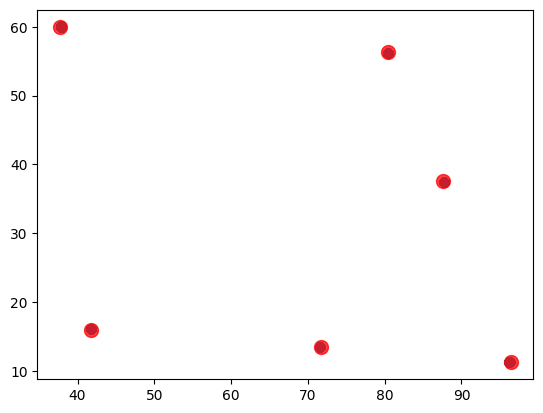

In [35]:
y = meanshift(x, cluster_bw, steps=5)
fig, ax = plt.subplots()
plot_sample(ax, y)
for center in centers:
    plot_center(ax, center)

In [36]:
%timeit -n 5 meanshift(x, cluster_bw, steps=5).block_until_ready()

822 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
